In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import yfinance as yf
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
market_caps = {}
for ticker in tqdm(index["ticker"]):
    try:
        stock_info = yf.Ticker(ticker).info
        market_caps[ticker] = stock_info['marketCap']
    except KeyError:
        market_caps[ticker] = None  # Handle missing data

# Convert to DataFrame
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['ticker', 'market_cap'])

print(market_caps_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:57<00:00,  8.78it/s]

    ticker    market_cap
0      MMM  7.089068e+10
1      AOS  9.922008e+09
2      ABT  1.994456e+11
3     ABBV  3.145686e+11
4      ACN  2.227835e+11
..     ...           ...
497    XYL  2.855332e+10
498    YUM  3.773891e+10
499   ZBRA  2.006823e+10
500    ZBH  2.127504e+10
501    ZTS  7.426176e+10

[502 rows x 2 columns]


In [5]:
model_start = 2013
model_end = 2020
backtest_end = 2025

In [6]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = price["date"].dt.year
        price["week"] = [x.week for x in price["date"]]
        sim = price[(price["year"]>=model_end-1) & (price["year"]<backtest_end)]
        sim["prediction"] = sim["adjclose"].rolling(100).mean()
        sim = sim.merge(macro,on="date",how="left")
        sim = CAPM.apply(sim)
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:03<00:21, 20.84it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:04<00:20, 20.61it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:29<00:00, 16.79it/s]

'date'


In [7]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left").merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["week"] = [x.week for x in simulation["date"]]
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["rank"] = simulation.groupby(["date", "GICS Sector"])["factor"].rank(method="dense", ascending=False).astype(int)

# Calculate the total number of ranks for each sector and date
simulation["total_ranks"] = simulation.groupby(["date", "GICS Sector"])["rank"].transform("max")

# Assign exposure based on rank
simulation["exposure"] = simulation.apply(
    lambda x: 1 if x["rank"] <= x["total_ranks"] * 0.50 else -1,
    axis=1
)

# Cleanup: Drop the total_ranks column if not needed
simulation.drop(columns=["total_ranks"], inplace=True)

# Sorting by date for further processing
simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]

In [8]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["week"] = [x.week for x in benchmark["date"]]
benchmark = benchmark[(benchmark["year"]>=model_end) & (benchmark["year"]<backtest_end)].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","week"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [9]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i+1,1))

In [10]:
filtered_columns = ["year","week","date","sell_date","GICS Sector","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","GICS Sector":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [11]:
simulation.tail()

,date,close,high,low,open,volume,adjclose,adjhigh,adjlow,adjopen,...,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,market_cap,rank,exposure,sell_price,sell_date
29539,2024-10-10,162.08,163.07,160.395,160.87,14144068,161.895367,162.884239,160.212287,160.686745,...,Interactive Media & Services,"Mountain View, California",2014-04-03,1652044,1998,2.366649e+12,6,1,161.895367,2024-10-10
580367,2024-10-10,126.74,128.29,126.090,127.90,2036417,126.740000,128.290000,126.090000,127.900000,...,Investment Banking & Brokerage,"St. Petersburg, Florida",2017-03-20,720005,1962,3.201874e+10,32,1,126.740000,2024-10-10
198151,2024-10-10,66.85,67.67,66.650,67.38,12759810,66.094408,66.905140,65.896669,66.618418,...,Health Care Services,"Woonsocket, Rhode Island",1957-03-04,64803,1996,5.598666e+10,53,-1,66.094408,2024-10-10
184825,2024-10-10,335.87,338.15,333.875,336.07,280358,335.870000,338.150000,333.875000,336.070000,...,Transaction & Payment Processing Services,"Atlanta, Georgia",2018-06-20,1175454,2000,2.378749e+10,67,-1,335.870000,2024-10-10
738336,2024-10-10,102.82,103.83,102.585,103.48,1090391,102.820000,103.830000,102.585000,103.480000,...,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927,2.127504e+10,9,1,102.820000,2024-10-10


In [12]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1,50,100,200]):
                for minimum_index in [0,50,100,200]:
                    for num_stocks_per_industry in [1,5]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = filtered_simulation[filtered_columns].groupby(["year","week","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","week","GICS Sector"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            analysis = trades[["year","week","exposure","return"]].groupby(["year","week","exposure"]).mean().pivot_table(index=["year","week"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","week","return"]].groupby(["year","week"]).mean().reset_index().sort_values(["year","week"])
                            portfolio["return"] = portfolio["return"] * 4 + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Week'] = portfolio["year"].astype(str) + "w" + portfolio["week"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","week"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:08<00:25,  8.49s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:16<00:16,  8.28s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:24<00:07,  7.98s/it]

100%|██████████████████████████████

In [13]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]

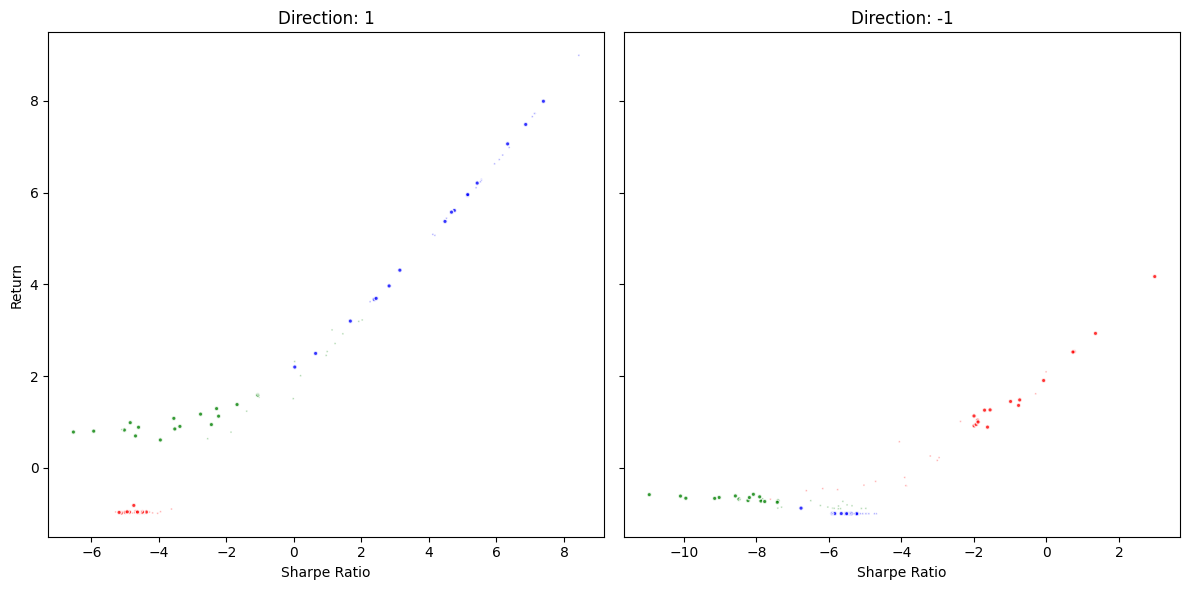

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = a[a["direction"] == direction]
    axes[i].scatter(
        d_analysis["sharpe"],
        d_analysis["return"],
        c=d_analysis["color"],
        s=d_analysis["stacks"] * 2,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sharpe Ratio")
    axes[i].set_ylabel("Return" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [15]:
a.sort_values("return",ascending=False).head(20)

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
30,1,1,200,200,1,2.189923,8.442073,8.991774,blue,4.105977
15,1,1,50,200,5,2.015056,7.391582,7.988987,blue,3.964648
12,1,1,50,100,1,2.086229,7.147098,7.724122,blue,3.702432
20,1,1,100,100,1,2.020969,7.126761,7.722418,blue,3.821145
2,1,1,1,50,1,2.034845,7.061285,7.652880,blue,3.760915
23,1,1,100,200,5,1.950000,6.866665,7.484001,blue,3.837950
7,1,1,1,200,5,1.650425,6.331146,7.060536,blue,4.278011
10,1,1,50,50,1,1.982046,6.375820,6.983174,blue,3.523214
14,1,1,50,200,1,1.907659,6.186157,6.817195,blue,3.573592
6,1,1,1,200,1,1.892006,6.081846,6.718105,blue,3.550784


In [16]:
value = 1
direction = 1
maximum_index = 1
minimum_index = 100
num_stocks_per_industry = 1
stacks = rank_list(value,num_stocks_per_industry)

In [23]:
stacks = rank_list(value,num_stocks_per_industry)
max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","week","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","week","GICS Sector"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
analysis = trades[["year","week","exposure","return"]].groupby(["year","week","exposure"]).mean().pivot_table(index=["year","week"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","week","return"]].groupby(["year","week"]).mean().reset_index().sort_values(["year","week"])
portfolio["return"] = portfolio["return"] * 4 + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-week'] = portfolio["year"].astype(str) + "q" + portfolio["week"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","week"],how="left")

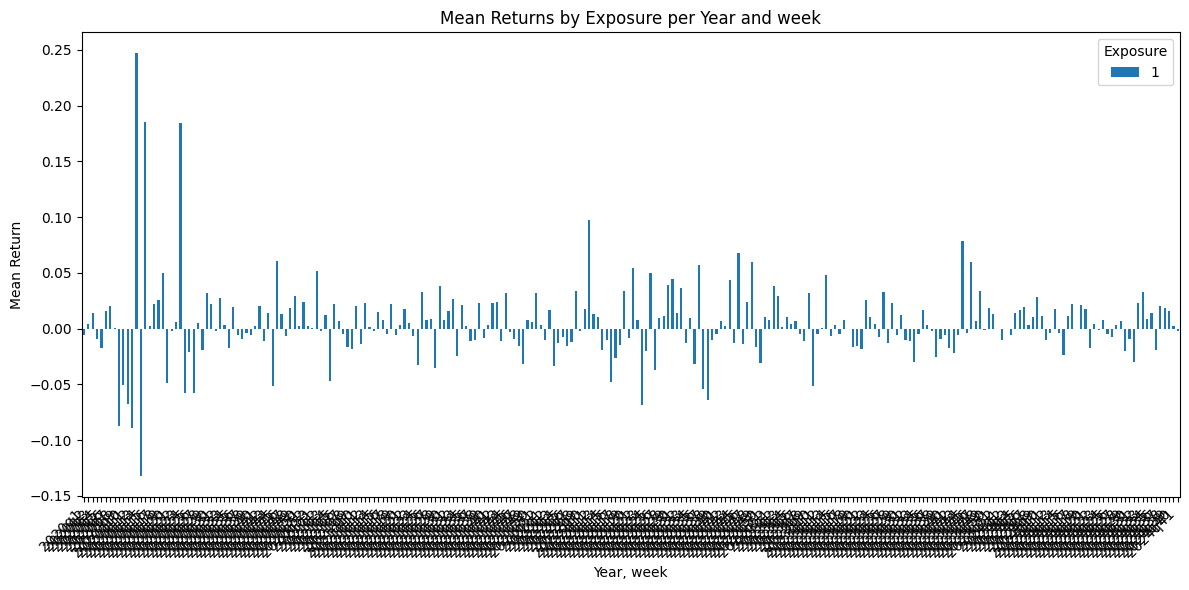

In [24]:
analysis['Year-Week'] = analysis["year"].astype(str) + "q" + analysis["week"].astype(str)

# Reset index for plotting
analysis.drop(["year","week"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Week").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and week"
)

# Customize the plot
plt.xlabel("Year, week")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


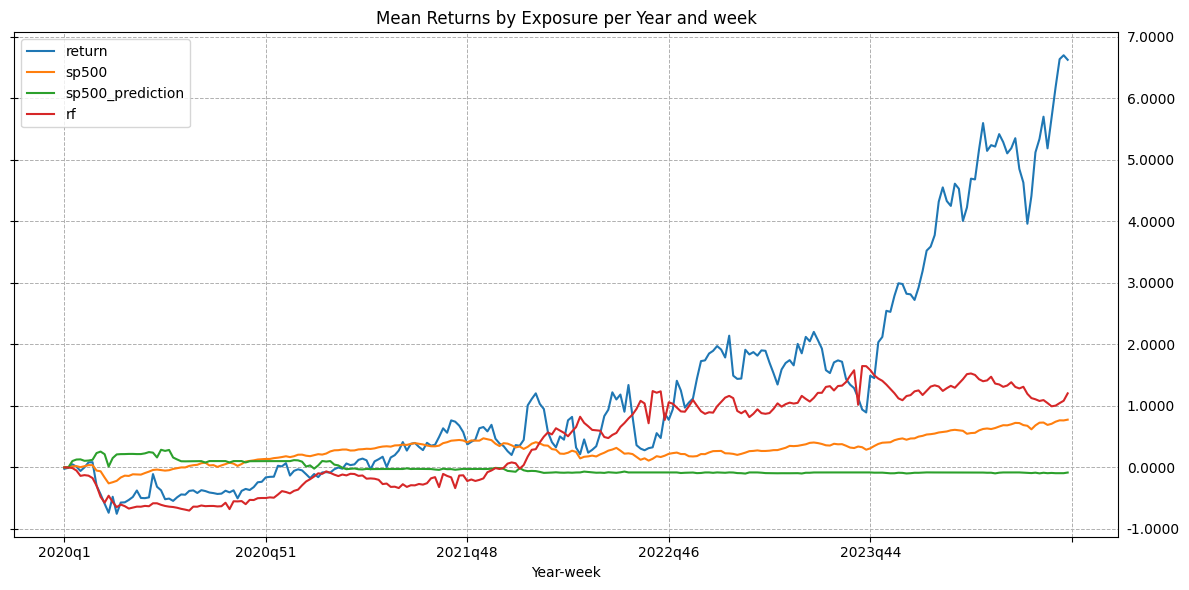

In [25]:
# Create the plot
ax = portfolio.drop(["date", "year", "week"], axis=1).set_index("Year-week").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and week"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [26]:
portfolio.tail()

,year,week,return,Year-week,date,sp500,sp500_prediction,rf
245,2024,37,5.683628,2024q37,2024-09-11,0.709149,-0.089299,0.993478
246,2024,38,6.179113,2024q38,2024-09-18,0.743627,-0.093385,1.004348
247,2024,39,6.635421,2024q39,2024-09-25,0.765509,-0.093331,1.045652
248,2024,40,6.698786,2024q40,2024-10-02,0.763937,-0.093258,1.083696
249,2024,41,6.624989,2024q41,2024-10-09,0.776407,-0.083033,1.203804


In [27]:
trades.groupby(["year","week","exposure","GICS Sector"]).agg({"return":"mean"}).tail(22)

return
year week exposure GICS Sector                     
2024 40   1        Communication Services  0.007745
                   Consumer Discretionary -0.010099
                   Consumer Staples       -0.022455
                   Energy                  0.036554
                   Financials              0.000370
                   Health Care            -0.011215
                   Industrials             0.004062
                   Information Technology -0.055244
                   Materials              -0.014942
                   Real Estate            -0.019091
                   Utilities               0.107137
     41   1        Communication Services  0.001444
                   Consumer Discretionary  0.004127
                   Consumer Staples        0.012464
                   Energy                 -0.022749
                   Financials              0.014360
                   Health Care            -0.008420
                   Industrials             0.002258
                   Information Technology  0.046523
                   Materials              -0.019540
                   Real Estate             0.005921
                   Utilities              -0.062748

In [28]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().cumsum().std())

4.672939581907131
